# Copyright

<PRE>
Jelen iPython notebook a Budapesti Műszaki és Gazdaságtudományi Egyetemen tartott "Deep Learning a gyakorlatban Python és LUA alapon" tantárgy segédanyagaként készült. 
A tantárgy honlapja: http://smartlab.tmit.bme.hu/oktatas-deep-learning
Deep Learning kutatás: http://smartlab.tmit.bme.hu/deep-learning

A notebook bármely részének újra felhasználása, publikálása csak a szerzők írásos beleegyezése esetén megegengedett.

2019 (c) Gyires-Tóth Bálint (toth.b kukac tmit pont bme pont hu), Császár Márk
</PRE>

# XOR probléma

Az előzőleg bemutatott XOR problémát e notebookban egy Python alapokra építkező, gépi tanulást elősegítő keretrendszerrel, a Kerassal fogjuk megoldani. A Keras az egyik legelterjedtebb mély tanuló keretrendszer, köszönhetően magas szintű megvalósításának. Backend-nek TensorFlow-t és Thenao-t is tud használni.
A kódunk elején betöltjük a Keras csomagból a szükséges modulokat.

In [1]:
# Először is, az egymáshoz képest lineárisan elhelyezkedő neurális hálózat modelljét.
from keras.models import Sequential
# Szükségünk van továbbá az előrecsatolt rétegekre, illetve a rajtuk elvégzett aktivációs függvényre.
from keras.layers.core import Dense, Activation
# A Callback függvény rengeteg hasznos információt szolgáltat a tanítási folyamat során, amelyekre kíváncsiak
# szoktunk lenni. 
from keras.callbacks import Callback
# A tanulási folyamat során a széles körben alkalmazott Stochastic Gradient Descent metódust alkalmazzuk mini-batch-eken.
# Ennek segítségével tudjuk a tanulási paramétereket szabályozni.
from keras.optimizers import SGD
# A jól ismert Numpy betöltése.
import numpy as np
# Standardizáláshoz
from sklearn import preprocessing
# Matplotlib grafikus megjelenítőcsomag meghívása
import matplotlib.pyplot as plt
%matplotlib inline

# Random seed-ek beállítása
np.random.seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

Using TensorFlow backend.


Az előbb már említett Callback függvényre alapozva a TrainingHistory osztállyal tudunk kinyerni értékes metrikákat, amelyek a hálózat tanulási folyamatát jellemzik. 

In [2]:
class TrainingHistory(Callback):
    # Tanulási folyamat elején létrehozunk egy-egy üres listát a kinyerni kívánt metrikák tárolása céljából.
    def on_train_begin(self, logs={}):
        # Hiba mértéke a tanító adatokon.
        self.losses = []
        # Hiba mértéke a validációs adatokon.
        self.valid_losses = []
        # A modell jóságát, pontosságát mérő mutatószám a tanító adatokon. 
        self.accs = []
        # A modell jóságát, pontosságát mérő mutatószám a validációs adatokon. 
        self.valid_accs = []
        # A tanítási fázisok sorszámozása.
        self.epoch = 0
    
    # Minden egyes tanítási fázis végén mentsük el, hogy hogyan teljesít aktuálisan a háló. 
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.valid_losses.append(logs.get('val_loss'))
        self.accs.append(logs.get('acc'))
        self.valid_accs.append(logs.get('val_acc'))
        self.epoch += 1
            
history = TrainingHistory()

In [3]:
# Modell felépítése
from keras import regularizers
# A modell struktúráját az egymásra linárisan épülő rétegek adják.
model = Sequential()
# Az első rejtett réteg definiálása, amely két bemenetről kapja az adatokat.
model.add(Dense(10, input_shape=(2,)))
# A rétegen alkalmazott szigmoid (hiperbolikus tanges) aktivációs függvény.
model.add(Activation("tanh"))
# Utolsó réteg definiálása, amelynek egy kimenete van.
model.add(Dense(1))
# A rétegen alkalmazott szigmoid (hiperbolikus tanges) aktivációs függvény.
model.add(Activation("tanh"))
# A tanulás előtt be kell állítani, hogy a tanulási folyamat milyen paraméterek mentén történjen.
# Az első paraméter a hiba meghatározására az átlagos négyzetes hiba értéket fogjuk alkalmazni.
model.compile(loss='mean_squared_error',
              # A korábbiakban már említett SGD optimatizáló metódusban tudjuk meghatározni a tanulási rátát
              # a momemtum módszer értékét, illetve, hogy használjon a háló Nesterov-momemtum módszert.
              optimizer= SGD(lr=0.1, momentum=0.001, nesterov=True),
              metrics=['accuracy'])

Tanító, validációs és tesztelő adatok megadása, standardizálása és megjelenítése:

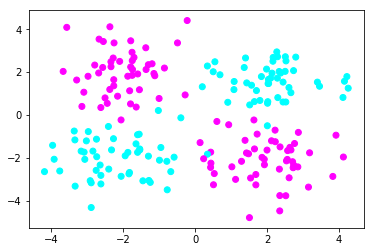

In [4]:
nb_samples=200
valid_split = 0.2
test_split = 0.1
samples=np.zeros(nb_samples, dtype=[('input', float, 2), ('output', float, 1)])
for i in range(0,nb_samples,4):
    noise = np.random.normal(0,1,8)
    samples[i] = (-2+noise[0],-2+noise[1]), 0
    samples[i+1] = (2+noise[2],-2+noise[3]), 1
    samples[i+2] = (-2+noise[4],2+noise[5]), 1
    samples[i+3] = (2+noise[6],2+noise[7]), 0

fig1=plt.figure()
plt.scatter(samples['input'][:,0],samples['input'][:,1],c=samples['output'][:], cmap=plt.cm.cool)

samples_train = samples[0:int(nb_samples*(1-valid_split-test_split))]
samples_valid = samples[int(nb_samples*(1-valid_split-test_split)):int(nb_samples*(1-test_split))]
samples_test  = samples[int(nb_samples*(1-test_split)):]
    
# standardizálás
scaler = preprocessing.StandardScaler().fit(samples_train['input'])
samples_train['input'] = scaler.transform(samples_train['input'])
samples_valid['input'] = scaler.transform(samples_valid['input'])
samples_test['input'] = scaler.transform(samples_test['input'])

A továbbiakban un. callback függvényeket adunk meg, melyeket tanítás során hív meg a Keras deep learning keretrendszer:

In [5]:
# Early stopping, amellyel figyeljük a validációs hibát (alap beállítás)
from keras.callbacks import EarlyStopping
patience=10
early_stopping=EarlyStopping(patience=patience, verbose=1)

# Szintén a validációs hibát figyeljük, és elmentjük a legjobb modellt
from keras.callbacks import ModelCheckpoint
checkpointer=ModelCheckpoint(filepath='weights.hdf5', save_best_only=True, verbose=1)

# a tanulálsi ráta (lr, learning rate) automatikus csökkentésére szolgáló függvény
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=20, min_lr=10e-5)

# a tanulási ráta kézzel írt szabályok alapján történő csökkentésére szolgáló függvény
# ezt most a tanítás során nem fogjuk használni, de érdemes kipróbálni a ReduceLROnPlateau
# függvény helyett
from keras.callbacks import LearningRateScheduler
def scheduler(epoch):
    result=0.1
    if (epoch>20):
        result=0.05
    if (epoch>40):
        result=10e-3
    if (epoch>60):
        result=0.1
    print("Learning rate: %f" % (result))
    return result

change_lr = LearningRateScheduler(scheduler)

# A háló tanítása és tesztelése

Tanítási folyamat és annak a paraméterei. A paraméterek sorát a tanulási adatokkal kell kezdeni. Ez után számos paramétert definiálhatunk, melyek rövid magyarázatát kommentekben olvashatjátok:

In [6]:
model.fit(samples_train['input'], samples_train['output'],
          # A tanulási folyamat során beállíthatjuk, hogy a tanító adatsorból hány elem kerüljön bele egy-egy
          # batch-be.
          batch_size=20,
          # Tanulási fázisok száma.
          nb_epoch=2500,
          # Verbose paraméter a tanulás során közli azokat az információkat, amelyek mi szeretnénk kinyerni.
          # Értéke lehet 0, 1 és 2
          verbose=2, 
          # A tanulással párhuzamosan a validáció is fut.
          validation_data=(samples_valid['input'],samples_valid['output']), 
          # A korábbiakban már tárgyalt tanulást jellemző metrikákat a history nevű változóban szeretnénk tárolni.
          callbacks=[reduce_lr, checkpointer, early_stopping, history], 
          # A bemenő adatokat keverje meg a program (alapbeállítás: True).
          shuffle= True)

C:\Users\Balint\Anaconda3\lib\site-packages\keras\models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 140 samples, validate on 40 samples
Epoch 1/2500
 - 0s - loss: 0.3103 - acc: 0.5500 - val_loss: 0.2464 - val_acc: 0.5750

Epoch 00001: val_loss improved from inf to 0.24642, saving model to weights.hdf5
Epoch 2/2500
 - 0s - loss: 0.2255 - acc: 0.6071 - val_loss: 0.2256 - val_acc: 0.6250

Epoch 00002: val_loss improved from 0.24642 to 0.22563, saving model to weights.hdf5
Epoch 3/2500
 - 0s - loss: 0.2058 - acc: 0.7357 - val_loss: 0.2091 - val_acc: 0.6500

Epoch 00003: val_loss improved from 0.22563 to 0.20913, saving model to weights.hdf5
Epoch 4/2500
 - 0s - loss: 0.1879 - acc: 0.7429 - val_loss: 0.1862 - val_acc: 0.8750

Epoch 00004: val_loss improved from 0.20913 to 0.18622, saving model to weights.hdf5
Epoch 5/2500
 - 0s - loss: 0.1662 - acc: 0.9071 - val_loss: 0.1726 - val_acc: 0.8500

Epoch 00005: val_loss improved from 0.18622 to 0.17264, saving model to weights.hdf5
Epoch 6/2500
 - 0s - loss: 0.1510 - acc: 0.8929 - val_loss: 0.1555 - val_acc: 0.9250

Epoch 00006: val_l


Epoch 00050: val_loss improved from 0.04884 to 0.04757, saving model to weights.hdf5
Epoch 51/2500
 - 0s - loss: 0.0481 - acc: 0.9714 - val_loss: 0.0474 - val_acc: 0.9750

Epoch 00051: val_loss improved from 0.04757 to 0.04740, saving model to weights.hdf5
Epoch 52/2500
 - 0s - loss: 0.0488 - acc: 0.9714 - val_loss: 0.0483 - val_acc: 1.0000

Epoch 00052: val_loss did not improve from 0.04740
Epoch 53/2500
 - 0s - loss: 0.0469 - acc: 0.9714 - val_loss: 0.0469 - val_acc: 0.9750

Epoch 00053: val_loss improved from 0.04740 to 0.04685, saving model to weights.hdf5
Epoch 54/2500
 - 0s - loss: 0.0477 - acc: 0.9714 - val_loss: 0.0469 - val_acc: 1.0000

Epoch 00054: val_loss did not improve from 0.04685
Epoch 55/2500
 - 0s - loss: 0.0466 - acc: 0.9714 - val_loss: 0.0464 - val_acc: 0.9750

Epoch 00055: val_loss improved from 0.04685 to 0.04638, saving model to weights.hdf5
Epoch 56/2500
 - 0s - loss: 0.0456 - acc: 0.9714 - val_loss: 0.0462 - val_acc: 1.0000

Epoch 00056: val_loss improved from

A hálózat hibájának megjelenítése mint a tanító, mind a validációs adathalmazon:

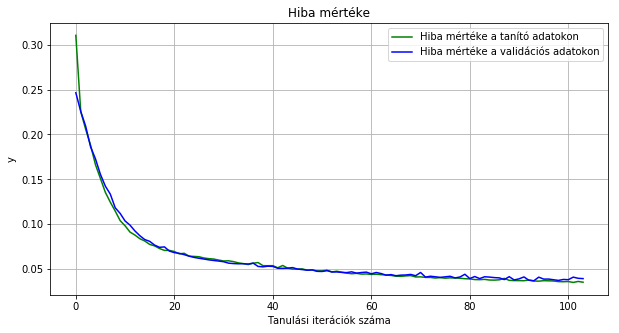

In [7]:
plt.figure(figsize=(10, 5))
plt.title('Hiba mértéke')
plt.plot(np.arange(history.epoch), history.losses, color ='g', label='Hiba mértéke a tanító adatokon') 
plt.plot(np.arange(history.epoch), history.valid_losses, color ='b', label='Hiba mértéke a validációs adatokon')
plt.legend(loc='upper right')
plt.xlabel('Tanulási iterációk száma')
plt.ylabel('y')
plt.grid(True)
plt.show()

Tesztelés és megjelenítés fázisa:

Test MSE: 0.058399


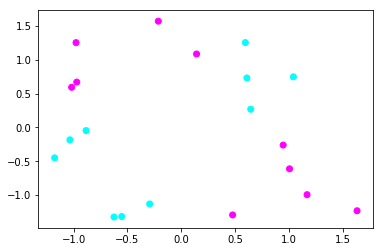

In [8]:
# a legjobb modell visszatöltése
from keras.models import load_model
model = load_model('weights.hdf5')
# teszt adatokkal prediktálás
preds=model.predict(samples_test['input'])
# hiba számítása a teszt adatokon
from sklearn.metrics import mean_squared_error
test_mse = mean_squared_error(samples_test['output'],preds)
print("Test MSE: %f" % (test_mse))
# predikció megjelenítése
fig1=plt.figure()
plt.scatter(samples_test['input'][:,0], \
            samples_test['input'][:,1], \
            c=np.round(preds[:,0]), cmap=plt.cm.cool)

# A modell vizsgálata

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                30        
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


In [10]:
print('Rétegek:\n')
for layer in model.layers:
    print("Réteg neve: ", layer.name, ', tanítható: ', layer.trainable)
    print(layer.get_config(),'\n')

Rétegek:

Réteg neve:  dense_1 , tanítható:  True
{'name': 'dense_1', 'trainable': True, 'batch_input_shape': (None, 2), 'dtype': 'float32', 'units': 10, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None} 

Réteg neve:  activation_1 , tanítható:  True
{'name': 'activation_1', 'trainable': True, 'activation': 'tanh'} 

Réteg neve:  dense_2 , tanítható:  True
{'name': 'dense_2', 'trainable': True, 'units': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regulari

In [11]:
print("Súlyok:")
i=1
for layer in model.layers:
    print(model.get_layer(index=i).get_weights())
    i=i+1

Súlyok:
[array([[-0.4456949 ,  0.62166244, -0.878075  ,  0.44380406, -0.6609749 ,
         0.03926218, -1.0423981 ,  0.3992914 , -0.91077375, -0.7941693 ],
       [ 0.9663357 ,  0.07527338,  0.33336622,  0.54156697, -0.03841925,
         0.3602769 , -1.0504563 ,  0.15033379, -0.7798919 ,  1.0122244 ]],
      dtype=float32), array([ 0.4591688 ,  0.00092774, -0.5361668 ,  0.19710967,  0.02002996,
       -0.23696852,  0.4487205 , -0.01318996, -0.5689842 , -0.9032697 ],
      dtype=float32)]
[]
[array([[-0.8834911 ],
       [ 0.22535603],
       [ 0.60769355],
       [ 0.31259802],
       [-0.44778255],
       [-0.6856303 ],
       [ 0.89173555],
       [ 0.05887592],
       [-1.0792385 ],
       [ 1.058259  ]], dtype=float32), array([0.9165903], dtype=float32)]
[]


# Feladat

Vizsgáljátok meg L1 és L2 regularizáció hatását a súly mátriuxra. 

Segítség:

```
from keras import regularizers
model.add(Dense(10, input_shape=(2,), kernel_regularizer=regularizers.l2(0.1)))
...
model.add(Dense(1, kernel_regularizer=regularizers.l2(0.1)))
```